# Part 1 - Regularization Techniques

## Objective

This lab applies four major regularization techniques to the deep models built in Lab 3 to combat overfitting:

- **ℓ₁ and ℓ₂ Regularization:** Adding a penalty to the loss function based on the size of the weights.
- **Dropout:** Randomly "killing" neurons during training to ensure the network doesn't over-rely on specific paths.
- **Max-Norm Regularization:** Constraining the weights of each neuron so they don't grow too large.

## Conceptual Background

| Technique | Description | Effect |
|-----------|-------------|--------|
| **ℓ₁ Regularization** | Adds penalty proportional to absolute weight values | Produces sparse models (weights become exactly zero), effectively acting as feature selection |
| **ℓ₂ Regularization** | Adds penalty proportional to squared weight values | Keeps weights small but rarely zero, helps handle multicollinearity |
| **Dropout** | Randomly deactivates neurons during training | Forces the network to learn redundant representations, making it more robust |
| **Max-Norm** | Rescales weight vector w such that \|\|w\|\|₂ ≤ c | Prevents weights from growing too large, where c is the max-norm hyperparameter |

## Step 1: $\ell_1$ and $\ell_2$
## RegularizationWe will apply these to a Dense network similar to your MNIST/CIFAR-10 tasks.

In [1]:
import tensorflow as tf
from tensorflow import keras

# 1. Define l2 regularization factor
# This adds a penalty to the loss: Loss + 0.01 * sum(weights^2)
regularizer = keras.regularizers.l2(0.01)

model_l2 = keras.Sequential([
    keras.Input(shape=(180, 180, 3)),# Using CIFAR-10 shape as example
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=regularizer),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                       kernel_regularizer=regularizer),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="softmax")
])

# If you want to use l1, simply use: keras.regularizers.l1(0.01)
# For both (Elastic Net style): keras.regularizers.l1_l2(0.01, 0.01)

model_l2.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

2026-02-19 08:47:12.089219: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/clauds/anaconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


## Step 2: Dropout
### Dropout is typically placed after each hidden layer.

In [2]:
model_dropout = keras.Sequential([
    keras.Input(shape=(32, 32, 3)),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    # 20% of the neurons will be dropped during each training step
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="softmax")
])

model_dropout.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

## Step 3: Max-Norm Regularization
### Max-norm doesn't add a penalty to the loss function; instead, it constrains the weights directly after each update.

In [3]:
# Define the constraint (e.g., max value of 1.0)
max_norm_reg = keras.constraints.max_norm(1.0)

model_max_norm = keras.Sequential([
    keras.Input(shape=(32, 32, 3)),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                       kernel_constraint=max_norm_reg),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                       kernel_constraint=max_norm_reg),
    keras.layers.Flatten(),
    keras.layers.Dense(10, activation="softmax")
])

model_max_norm.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

# Part 2 - Data Augmentation

## Objective

This lab demonstrates how to use TensorFlow Flowers to practice data augmentation. We will explore three ways to implement this:

- **Integrated Layers:** Adding augmentation directly into the Sequential model.
- **Dataset Mapping:** Applying transformations to the `tf.data` pipeline for better performance.
- **Custom Augmentation:** Using `tf.image` for fine-grained control over specific transformations.

## Why use Data Augmentation?

Data Augmentation is a powerful technique used to artificially expand the size of your training set by creating "new" images from existing ones using transformations like rotation, flipping, and zooming. This prevents the model from memorizing specific orientations and helps it generalize better to real-world photos.

| Benefit | Description |
|---------|-------------|
| **Reduces Overfitting** | By showing the model a slightly different version of the image every time, it can't rely on the exact position of pixels |
| **Invariance** | The model learns that a flower is still the same flower even if it is upside down, flipped, or slightly rotated |

### Step 1: Load and Pre-process the Flowers Dataset

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# 1. Load the tf_flowers dataset
# as_supervised=True gives us (image, label) pairs instead of a dictionary
(train_ds, val_ds), ds_info = tfds.load(
    'tf_flowers',
    #Take everything from the very beginning up to the 80% mark. This becomes your Training Set. Take everything starting from the 80% mark until the very end. This becomes your Validation Set.
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

# 2. Define image size and batch size
IMG_SIZE = 180
BATCH_SIZE = 32

# 3. Resize and Rescale function
# Images come in different sizes; we need them uniform for the neural network
resize_and_rescale = keras.Sequential([
  layers.Resizing(IMG_SIZE, IMG_SIZE),
  layers.Rescaling(1./255) # Scales pixels from [0, 255] to [0, 1]
])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /home/clauds/tensorflow_datasets/tf_flowers/incomplete.8VO2VD_3.0.1/tf_flowers-train.tfrecord*...:  …

Dataset tf_flowers downloaded and prepared to /home/clauds/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


### Step 2: Integrated Data Augmentation Layers
The easiest way to augment is to make it the first layer of your model. Note that these layers are only active during training; they automatically turn off during testing.

In [5]:
# Create the augmentation "block"
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"), # Flips the image randomly
  layers.RandomRotation(0.2),                   # Rotates by up to 20% (72 degrees)
  layers.RandomContrast(0.1),                   # Randomly changes brightness contrast
])

# Build the model with augmentation included
model = keras.Sequential([
  resize_and_rescale,
  data_augmentation, # Augmentation happens right here inside the model
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(5) # 5 classes for tf_flowers
])

### Step 3: Custom Data Augmentation Layer
For finer control, we can inherit from layers.Layer and use the tf.image library. This is useful if you want to add specific noise or transformations not found in standard Keras layers.

In [9]:
class MyCustomAugmentation(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, images, training=True):
        if not training:
            return images # Do nothing if we are just testing/predicting

        # Use tf.image for custom logic
        # Example: Randomly adjust brightness
        images = tf.image.random_brightness(images, max_delta=0.5)
        # Example: Randomly flip left to right
        images = tf.image.random_flip_left_right(images)
        return images

# Usage in a model:
# model.add(MyCustomAugmentation())

### Step 4: Building the Pipeline and Training
To ensure training is fast, we use .prefetch() and .cache() so the CPU prepares the next batch while the GPU is busy training.

In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds

# Your existing data loading (keep this as is)
(train_ds, val_ds), ds_info = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    with_info=True
)

# 1. Define layers INDIVIDUALLY
resizing_layer = layers.Resizing(180, 180)
rescaling_layer = layers.Rescaling(1./255)

# 2. Define Augmentation layers individually
flip_layer = layers.RandomFlip("horizontal_and_vertical")
rotation_layer = layers.RandomRotation(0.2)

# 3. Updated prepare function for TFDS format
def prepare(ds, shuffle=False, augment=False):
    # Step A: Resize and Rescale
    ds = ds.map(lambda x, y: (resizing_layer(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.map(lambda x, y: (rescaling_layer(x), y),
                num_parallel_calls=tf.data.AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    # Step B: Batch the data
    ds = ds.batch(32)

    # Step C: Augment the BATCH
    if augment:
        # Apply augmentation to the batched data
        def augment_batch(x, y):
            x = flip_layer(x, training=True)
            x = rotation_layer(x, training=True)
            return x, y

        ds = ds.map(augment_batch, num_parallel_calls=tf.data.AUTOTUNE)

    return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

# 4. Prepare the datasets
train_ds_final = prepare(train_ds, shuffle=True, augment=True)
val_ds_final = prepare(val_ds)

# 5. The Model
model = keras.Sequential([
    layers.Input(shape=(180, 180, 3)),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5)  # 5 classes for flowers
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# 6. Train
model.fit(train_ds_final, validation_data=val_ds_final, epochs=10)

Epoch 1/10


2026-02-19 09:04:09.928072: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2026-02-19 09:04:12.947298: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 132710400 exceeds 10% of free system memory.
2026-02-19 09:04:14.869782: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 132710400 exceeds 10% of free system memory.


 1/92 ━━━━━━━━━━━━━━━━━━━━ 11:48 8s/step - accuracy: 0.1875 - loss: 1.5929

2026-02-19 09:04:15.533652: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 132710400 exceeds 10% of free system memory.
2026-02-19 09:04:16.822569: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 132710400 exceeds 10% of free system memory.


 2/92 ━━━━━━━━━━━━━━━━━━━━ 2:43 2s/step - accuracy: 0.2266 - loss: 2.4502 

2026-02-19 09:04:17.355243: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:84] Allocation of 132710400 exceeds 10% of free system memory.


92/92 ━━━━━━━━━━━━━━━━━━━━ 221s 2s/step - accuracy: 0.4131 - loss: 1.7139 - val_accuracy: 0.5136 - val_loss: 1.2212
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.5259 - loss: 1.1517 - val_accuracy: 0.5858 - val_loss: 1.0121
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.5865 - loss: 1.0409 - val_accuracy: 0.5913 - val_loss: 1.0249
Epoch 4/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 284s 3s/step - accuracy: 0.6308 - loss: 0.9541 - val_accuracy: 0.6376 - val_loss: 0.9374
Epoch 5/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 265s 3s/step - accuracy: 0.6468 - loss: 0.9001 - val_accuracy: 0.6362 - val_loss: 0.8895
Epoch 6/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 153s 2s/step - accuracy: 0.6485 - loss: 0.8972 - val_accuracy: 0.6240 - val_loss: 0.9609
Epoch 7/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 127s 1s/step - accuracy: 0.6689 - loss: 0.8582 - val_accuracy: 0.6894 - val_loss: 0.8190
Epoch 8/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.6771 - loss: 0.8196 - val_accuracy: 0.6540 - val_loss: 0.

# Part 3 - Multi-Task Learning (MTL)

## Objective

Build a multi-output model using the Functional API in Keras to perform two classifications simultaneously on CIFAR-10 data:

- **Task A (Multi-class):** Identify the specific object (airplane, automobile, bird, cat, dog, frog, ship, or truck).
- **Task B (Binary):** Classify the object into a broader category: Animal vs. Vehicle.

## Why Multi-Task Learning?

| Benefit | Description |
|---------|-------------|
| **Shared Features** | The model uses the same initial layers to extract edges, shapes, and textures. These features are useful for both tasks. |
| **Regularization** | Learning Task B can help the model perform better on Task A by forcing it to learn more generalized representations of what an "animal" or "vehicle" looks like. |

### Step 1: Pre-processing & Label Engineering
Since CIFAR-10 only provides 10 classes, we need to manually create the labels for our second task (Animal vs. Vehicle).

In [17]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

# 1. Load CIFAR-10
# Note: we use y_train_full and y_test to match the standard loading pattern
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.cifar10.load_data()

# 2. Normalize pixel values
# Neural networks work best when inputs are between 0 and 1
X_train_full = X_train_full.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# 3. Create Binary Labels (Task B)
# CIFAR-10 indices for Vehicles: 0, 1, 8, 9
# CIFAR-10 indices for Animals: 2, 3, 4, 5, 6, 7
def create_binary_labels(labels):
    # This creates a 1D array where 1 = Animal and 0 = Vehicle
    return np.array([1 if label in [2, 3, 4, 5, 6, 7] else 0 for label in labels])

# We call the function using the variables we just loaded
y_train_binary = create_binary_labels(y_train_full)
y_test_binary = create_binary_labels(y_test) # Corrected variable name from y_test_full

print(f"X_train shape: {X_train_full.shape}")
print(f"Binary labels created for {len(y_train_binary)} training samples.")

X_train shape: (50000, 32, 32, 3)
Binary labels created for 50000 training samples.


### Step 2: Build the Functional Model
Because this model has two outputs, we cannot use the Sequential API. We must use the Functional API to define how data flows through the shared layers into two separate classification "heads".

In [22]:
# Define the Input layer
inputs = layers.Input(shape=(32, 32, 3), name="img_input")

# --- SHARED CONVOLUTIONAL LAYERS ---
# These layers learn general features like edges and textures
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)
x = layers.Flatten()(x)
shared_features = layers.Dense(128, activation='relu')(x)

# --- TASK A HEAD: 10-class Classification ---
# Outputting probabilities for each of the 10 CIFAR classes
output_class = layers.Dense(10, activation='softmax', name='class_output')(shared_features)

# --- TASK B HEAD: Binary Classification ---
# Outputting a single probability (0 to 1) for Animal vs Vehicle
output_binary = layers.Dense(1, activation='sigmoid', name='binary_output')(shared_features)

# Create the multi-output model
model_mtl = keras.Model(inputs=inputs, outputs=[output_class, output_binary])

# Compile with two losses: Categorical for Task A and Binary for Task B
# Re-run this cell to update the model configuration
model_mtl.compile(
    optimizer='adam',
    loss={
        'class_output': 'sparse_categorical_crossentropy',
        'binary_output': 'binary_crossentropy'
    },
    # FIX: We provide a dictionary so both outputs get an accuracy metric
    metrics={
        'class_output': ['accuracy'],
        'binary_output': ['accuracy']
    }
)

### Step 3: Multi-Task Training
When training, we pass the two different label sets as a dictionary.

In [23]:
# Train the model on both sets of labels at once
history = model_mtl.fit(
    X_train_full,
    {'class_output': y_train_full, 'binary_output': y_train_binary},
    epochs=10,
    batch_size=64,
    validation_split=0.2
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 75s 117ms/step - binary_output_accuracy: 0.8794 - binary_output_loss: 0.2923 - class_output_accuracy: 0.4643 - class_output_loss: 1.4901 - loss: 1.7824 - val_binary_output_accuracy: 0.8908 - val_binary_output_loss: 0.2742 - val_class_output_accuracy: 0.5451 - val_class_output_loss: 1.3120 - val_loss: 1.5836
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 124ms/step - binary_output_accuracy: 0.9127 - binary_output_loss: 0.2205 - class_output_accuracy: 0.5986 - class_output_loss: 1.1388 - loss: 1.3593 - val_binary_output_accuracy: 0.9231 - val_binary_output_loss: 0.2011 - val_class_output_accuracy: 0.6334 - val_class_output_loss: 1.0582 - val_loss: 1.2564
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 88s 134ms/step - binary_output_accuracy: 0.9270 - binary_output_loss: 0.1867 - class_output_accuracy: 0.6556 - class_output_loss: 0.9870 - loss: 1.1738 - val_binary_output_accuracy: 0.9223 - val_binary_output_loss: 0.1960 - val_class_output_accuracy: 0.6468 - va

### Step 4: Plotting the Multi-Task History
This code will generate a 2x2 grid so you can see Loss and Accuracy for both Task A and Task B at the same time.

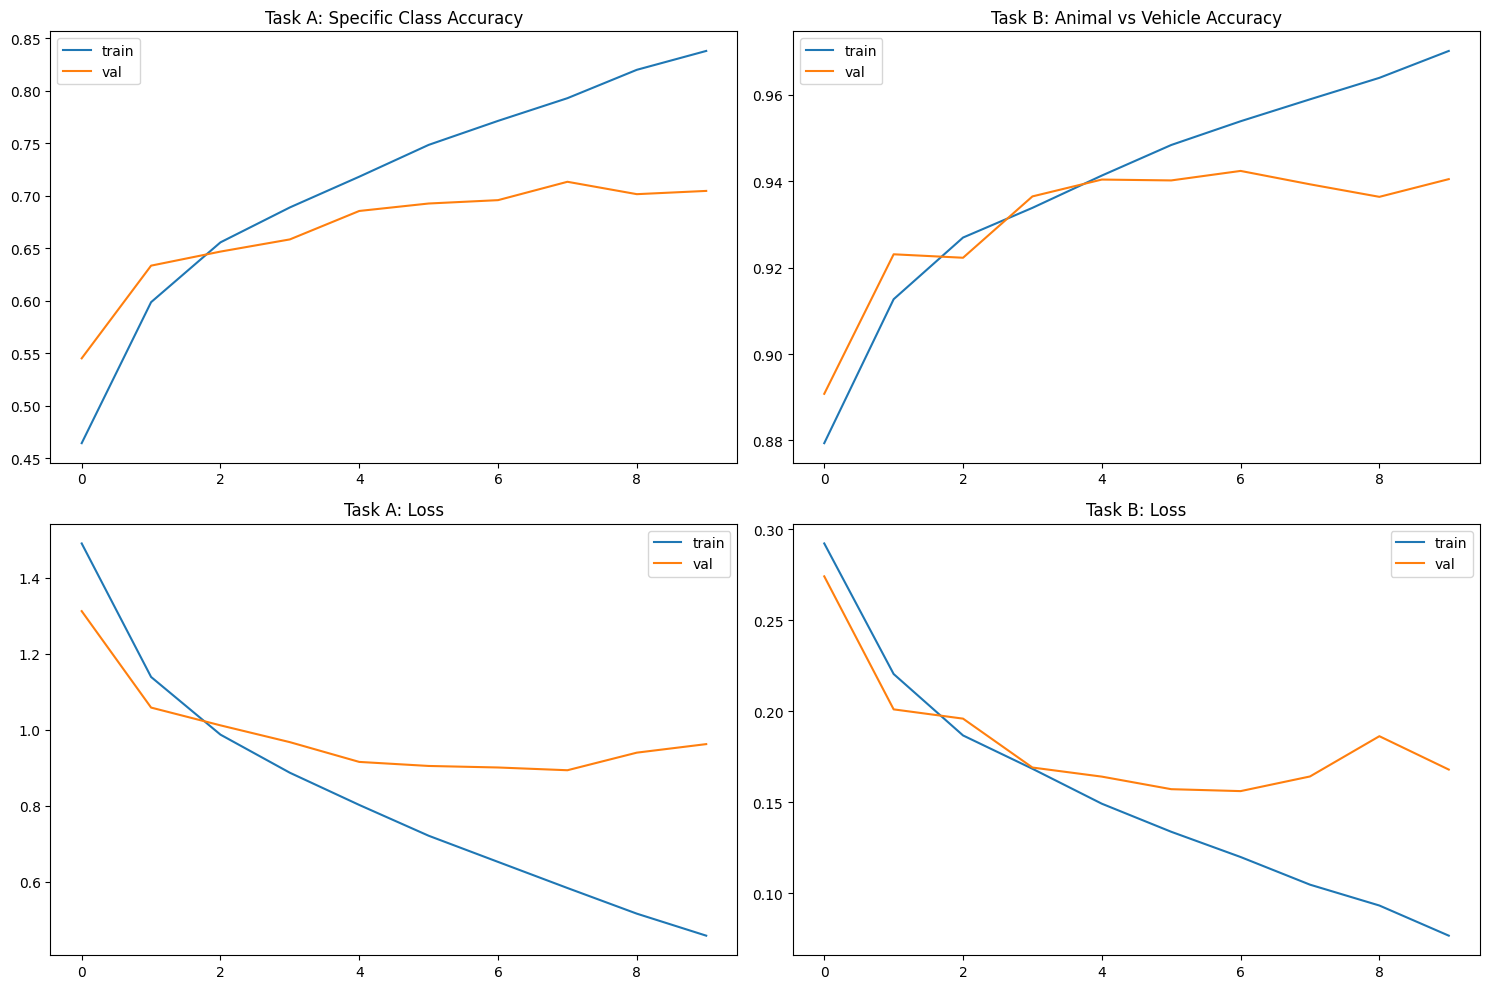

In [24]:
import matplotlib.pyplot as plt

def plot_mtl_history(history):
    # Set up a grid of 2 rows and 2 columns
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Plot Class Output Accuracy (Task A)
    axs[0, 0].plot(history.history['class_output_accuracy'], label='train')
    axs[0, 0].plot(history.history['val_class_output_accuracy'], label='val')
    axs[0, 0].set_title('Task A: Specific Class Accuracy')
    axs[0, 0].legend()

    # 2. Plot Binary Output Accuracy (Task B)
    axs[0, 1].plot(history.history['binary_output_accuracy'], label='train')
    axs[0, 1].plot(history.history['val_binary_output_accuracy'], label='val')
    axs[0, 1].set_title('Task B: Animal vs Vehicle Accuracy')
    axs[0, 1].legend()

    # 3. Plot Class Output Loss
    axs[1, 0].plot(history.history['class_output_loss'], label='train')
    axs[1, 0].plot(history.history['val_class_output_loss'], label='val')
    axs[1, 0].set_title('Task A: Loss')
    axs[1, 0].legend()

    # 4. Plot Binary Output Loss
    axs[1, 1].plot(history.history['binary_output_loss'], label='train')
    axs[1, 1].plot(history.history['val_binary_output_loss'], label='val')
    axs[1, 1].set_title('Task B: Loss')
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()

# Run the visualization
plot_mtl_history(history)

### Step 5: Saving the Multi-Output Model
Since this model has a unique structure, saving it correctly is important so you can reload it later for your lab demonstration.

In [25]:
# Save the entire Functional model
model_mtl.save("cifar10_multi_task_model.keras")

# Example of how to load it back
# loaded_mtl_model = keras.models.load_model("cifar10_multi_task_model.keras")
print("Multi-Task model saved successfully!")

Multi-Task model saved successfully!


# Part 4 - Bagging Ensemble with Neural Networks

## Objective

We will create an ensemble of Deep Learning models to solve a 2D classification problem. The core idea is that the average of many models is often more accurate and stable than any single model alone.

## What is Bagging?

Bagging (Bootstrap Aggregating) is a powerful way to make your neural networks more robust. Instead of relying on one "expert" model, you train a "committee" of models and let them vote on the final answer.

| Step | Description |
|------|-------------|
| **Bootstrapping** | Create "new" versions of our dataset by randomly picking samples (with replacement) |
| **Parallel Training** | Multiple models are trained independently on these different versions of the data |
| **Aggregating** | For classification, take the majority vote (or average the probabilities) to get the final result |

### Step 1: Create the Dataset
We use make_blobs to create a synthetic 2D dataset and convert it to Pandas for easier handling.

In [30]:
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.utils import to_categorical

# 1. Generate 2D classification dataset
# centers=3 means we have 3 classes to predict ---- increase the noise from 2 to 5
X, y = make_blobs(n_samples=1000, centers=3, n_features=2,
                  cluster_std=5.0, random_state=42)
# 2. Convert to DataFrame
df_X = pd.DataFrame(X, columns=['Feature1', 'Feature2'])
df_y = pd.Series(y)

# 3. Convert target to categorical (One-Hot Encoding)
# This is necessary for the multi-class output of the neural network
y_cat = to_categorical(y)

# 4. Split into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(df_X, y_cat, test_size=0.2, random_state=42)

print(f"Dataset ready. Classes: {y_cat.shape[1]}")

Dataset ready. Classes: 3


### Step 2: Functions for Ensemble Training and Evaluation
To keep things clean, we will write functions that can build models and combine their predictions.

In [31]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

# A function to build and train a single "weak" model
def fit_model(X_train, y_train):
    model = Sequential([
        Dense(5, input_dim=2, activation='relu'), # Fewer neurons
        Dense(3, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, verbose=0) # Fewer epochs --- reduce from 50 to 10 epochs
    return model

# A function to make an ensemble prediction
def ensemble_predictions(members, X_test):
    # Get predictions from every single model in our list
    y_hats = [model.predict(X_test, verbose=0) for model in members]
    y_hats = np.array(y_hats)

    # Sum the probabilities across all models (Aggregating)
    summed = np.sum(y_hats, axis=0)

    # The final class is the one with the highest total probability
    result = np.argmax(summed, axis=1)
    return result

# A function to evaluate the ensemble's accuracy
from sklearn.metrics import accuracy_score

def evaluate_ensemble(members, X_test, y_test):
    # Get the ensemble's vote
    y_pred = ensemble_predictions(members, X_test)
    # Convert one-hot y_test back to integers for comparison
    y_true = np.argmax(y_test, axis=1)
    # Return the accuracy score
    return accuracy_score(y_true, y_pred)

### Step 3: Evaluate Different Ensemble Sizes
We will now see if adding more models actually helps.

In [32]:
# 1. Train a "pool" of 20 models
n_members = 20
members = [fit_model(X_train, y_train) for _ in range(n_members)]

# 2. Evaluate accuracy as we add more models to the committee
ensemble_scores = []
for i in range(1, n_members + 1):
    # Evaluate using the first 'i' models
    subset = members[:i]
    score = evaluate_ensemble(subset, X_test, y_test)
    ensemble_scores.append(score)
    print(f"Ensemble size {i}: Accuracy = {score:.4f}")

/home/clauds/anaconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/clauds/anaconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/clauds/anaconda3/envs/tf_env/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super

Ensemble size 1: Accuracy = 0.6550
Ensemble size 2: Accuracy = 0.7450
Ensemble size 3: Accuracy = 0.7700
Ensemble size 4: Accuracy = 0.8200
Ensemble size 5: Accuracy = 0.8300
Ensemble size 6: Accuracy = 0.8200
Ensemble size 7: Accuracy = 0.8450
Ensemble size 8: Accuracy = 0.8500
Ensemble size 9: Accuracy = 0.8550
Ensemble size 10: Accuracy = 0.8650
Ensemble size 11: Accuracy = 0.8550
Ensemble size 12: Accuracy = 0.8550
Ensemble size 13: Accuracy = 0.8450
Ensemble size 14: Accuracy = 0.8500
Ensemble size 15: Accuracy = 0.8450
Ensemble size 16: Accuracy = 0.8500
Ensemble size 17: Accuracy = 0.8400
Ensemble size 18: Accuracy = 0.8500
Ensemble size 19: Accuracy = 0.8650
Ensemble size 20: Accuracy = 0.8500


### Step 4: Plotting Score vs. Number of Members

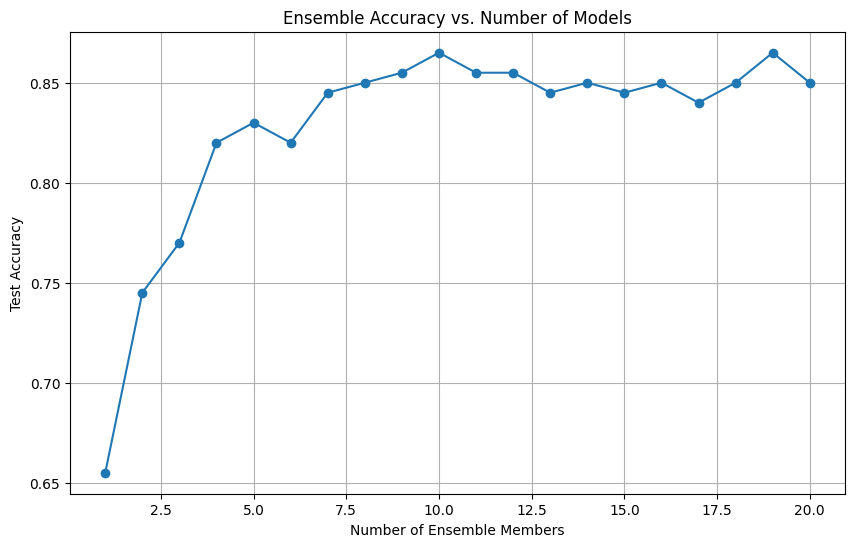

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_members + 1), ensemble_scores, marker='o')
plt.title('Ensemble Accuracy vs. Number of Models')
plt.xlabel('Number of Ensemble Members')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.show()

### Analyzing the Ensemble Evolution

#### 1. The "Perfect" Baseline (Image 3)

In your first attempt, the graph was a flat line at 99.5%.

**What happened:** The clusters were so distinct that every single model learned the boundary perfectly on the first try.

**Conclusion:** There was no "variance" to reduce because every model was already an expert. An ensemble of 20 experts gives the same answer as 1 expert.

#### 2. The "Real-World" Learning Curve (Image 4)

After increasing the noise (cluster standard deviation), you got the "staircase" effect we were looking for!

| Phase | Description |
|-------|-------------|
| **Initial State** | A single model (1 member) only achieved about 65% accuracy. It was a "weak learner" struggling with the overlapping data. |
| **The Climb** | As you added members 2 through 10, the accuracy shot up from 65% to over 85%. |
| **The Plateau** | After about 10 members, the accuracy stabilized. This shows the **Law of Diminishing Returns**—eventually, adding more models doesn't provide new information, and the average accuracy plateaus. |

### Step 5: Final Evaluation & Discussion
Now that your bagging experiment is successful, you can add this final analysis to your Jupyter Notebook.

In [34]:
# Final summary of your findings
best_ensemble_score = max(ensemble_scores)
initial_score = ensemble_scores[0]
improvement = best_ensemble_score - initial_score

print(f"Single Model Accuracy: {initial_score:.4f}")
print(f"Best Ensemble Accuracy: {best_ensemble_score:.4f}")
print(f"Total Improvement: {improvement*100:.2f}%")

Single Model Accuracy: 0.6550
Best Ensemble Accuracy: 0.8650
Total Improvement: 21.00%
